In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm
!pip install albumentations
!pip install segmentation_models_pytorch

In [ ]:
import torch
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os,psutil

import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as F

import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm
import cv2

import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import cv2
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils import metrics, losses, base
import random
import matplotlib.pyplot as plt
import os
from datetime import datetime
from copy import deepcopy
import pickle

In [ ]:
Device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
image_size = 224
batch_size = 16

In [ ]:

unet_model= smp.Unet('tu-efficientnetv2_rw_m.agc_in1k', encoder_weights='/content/drive/MyDrive/Copy_of_sslTrainedEfficientnet', classes=2, activation='sigmoid', encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [ ]:
efficientnet_weights = torch.load('/content/drive/MyDrive/Copy_of_sslTrainedEfficientnet')
unet_model.encoder.load_state_dict(efficientnet_weights, strict=False)

_IncompatibleKeys(missing_keys=['model.conv_stem.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.blocks.0.0.conv_exp.weight', 'model.blocks.0.0.bn1.weight', 'model.blocks.0.0.bn1.bias', 'model.blocks.0.0.bn1.running_mean', 'model.blocks.0.0.bn1.running_var', 'model.blocks.0.0.conv_pwl.weight', 'model.blocks.0.0.bn2.weight', 'model.blocks.0.0.bn2.bias', 'model.blocks.0.0.bn2.running_mean', 'model.blocks.0.0.bn2.running_var', 'model.blocks.0.1.conv_exp.weight', 'model.blocks.0.1.bn1.weight', 'model.blocks.0.1.bn1.bias', 'model.blocks.0.1.bn1.running_mean', 'model.blocks.0.1.bn1.running_var', 'model.blocks.0.1.conv_pwl.weight', 'model.blocks.0.1.bn2.weight', 'model.blocks.0.1.bn2.bias', 'model.blocks.0.1.bn2.running_mean', 'model.blocks.0.1.bn2.running_var', 'model.blocks.0.2.conv_exp.weight', 'model.blocks.0.2.bn1.weight', 'model.blocks.0.2.bn1.bias', 'model.blocks.0.2.bn1.running_mean', 'model.blocks.0.2.bn1.running_var', 'model.b

In [ ]:
import albumentations as album

def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=224, width=224, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


import albumentations as album

def get_preprocessing(preprocessing_fn=None, image_size=(224, 224), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    _transform = []

    # Resize the image to the specified size
    _transform.append(album.Resize(height=image_size[0], width=image_size[1]))

    if preprocessing_fn:
        # Apply preprocessing function
        _transform.append(album.Lambda(image=preprocessing_fn))

    # Normalize the image
    #_transform.append(album.Normalize(mean=mean, std=std))

    # Convert the image and mask to tensors
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

In [ ]:
class cellDataset(torch.utils.data.Dataset):

    def __init__(
            self,
            ids,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in ids]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in ids]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.imread(self.image_paths[i])
        mask = cv2.imread(self.mask_paths[i])

        new_width=224
        new_height = 224
        image = cv2.resize(image, (new_width, new_height))
        mask = cv2.resize(mask, (new_width, new_height))
        #print(self.image_paths[i])
        #print(self.mask_paths[i])
        #print(mask.shape)
        # one-hot-encode the mask
        #mask = one_hot_encode(mask).astype('float
        image = image/225.0
        mask = mask.reshape(224,224,3)


        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        mask = (mask > 0).astype(np.float32)

        # Stack the binary mask to create a (224, 224, 2) mask
        mask = np.stack([1 - mask, mask], axis=-1)
        image = torch.FloatTensor(image.transpose(2, 0, 1))  # Channel-first format
        mask = torch.FloatTensor(mask.transpose(2, 0, 1))  # Channel-first format
        #print(image.shape)
        #print(mask.shape)

        #mask = torch.FloatTensor(mask.transpose(2, 0, 1))
        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

In [ ]:
from timm.data.transforms_factory import transforms_imagenet_eval
x_train_dir = "/content/shared-data-sept/image"
y_train_dir="/content/shared-data-sept/mask"
image_files = sorted(os.listdir(x_train_dir))
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
train_dataset = cellDataset(train_files,x_train_dir, y_train_dir,augmentation=get_training_augmentation())
val_dataset = cellDataset(test_files,x_train_dir, y_train_dir)



In [ ]:
x,y = train_dataset[1]

print(y.shape)

torch.Size([2, 224, 224])


In [ ]:

from torch.utils.data import DataLoader, random_split

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:

TRAINING = True

# Set num of epochs
EPOCHS = 200
model = unet_model
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]

loss = smp.utils.losses.DiceLoss()

# define metrics

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)


In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
import torch
from sklearn.metrics import f1_score

def calculate_f1_score(val_loader, model, threshold=0.5):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)  # Assuming you have a device variable set (e.g., device = torch.device("cuda") or "cpu")
            targets = targets.to(DEVICE)

            # Forward pass to get predictions
            outputs = model(inputs)

            # Apply a threshold to convert probabilities to binary predictions
            predicted_labels = (outputs > threshold).float()

            all_predictions.append(predicted_labels.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Concatenate predictions and targets for all batches
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    # Calculate the F1 score
    f1 = f1_score(all_targets, all_predictions)

    return f1


In [ ]:
import torch

def dice_coeff(pred, target):
    smooth = 1e-5  # Smoothing factor to avoid division by zero
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() + smooth
    dice = (2.0 * intersection + smooth) / union
    return dice

def calculate_dice_score(val_loader, model):
    model.eval()
    total_dice = 0.0
    num_samples = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)  # Assuming you have a device variable set (e.g., device = torch.device("cuda") or "cpu")
            targets = targets.to(DEVICE)

            # Forward pass to get predictions
            outputs = model(inputs)

            # Apply a threshold or softmax to the outputs if necessary
            # For example, if outputs are logits, you may apply softmax:
            # probs = torch.softmax(outputs, dim=1)

            # Convert to binary masks if needed
            # For example, if probs are probabilities, you can threshold to get binary masks:
            # predicted_masks = (probs > threshold).float()

            # Calculate Dice coefficient for this batch
            batch_dice = dice_coeff(outputs, targets)

            total_dice += batch_dice.item()
            num_samples += inputs.size(0)

    # Calculate the average Dice coefficient across all batches
    average_dice = total_dice / num_samples

    return average_dice


In [ ]:
%%time

vals=[]
train=[]
EPOCHS=200
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        valF1 = calculate_dice_score(valid_loader,model)
        vals.append(valF1)
        trainF1 = calculate_dice_score(valid_loader,model)
        train.append(trainF1)
        print(f"F1 score: {valF1} TrainF1score: {trainF1}")
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 10/10 [00:00<00:00, 19.16it/s, dice_loss - 0.4714, iou_score - 0.7223, precision - 0.9764, recall - 0.7351, accuracy - 0.8587, fscore - 0.8387]
F1 score: 0.5285483002662659 TrainF1score: 0.5285483002662659
Model saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:00<00:00, 22.21it/s, dice_loss - 0.5018, iou_score - 0.09551, precision - 0.7369, recall - 0.09892, accuracy - 0.5317, fscore - 0.1743]
F1 score: 0.4981851249933243 TrainF1score: 0.4981851249933243

Epoch: 2
valid: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s, dice_loss - 0.5267, iou_score - 0.04213, precision - 0.08175, recall - 0.07995, accuracy - 0.09101, fscore - 0.08084]
F1 score: 0.4733069151639938 TrainF1score: 0.4733069151639938

Epoch: 3
valid: 100%|██████████| 10/10 [00:00<00:00, 21.37it/s, dice_loss - 0.5294, iou_score - 0.03651, precision - 0.07024, recall - 0.07061, accuracy - 0.06805, fscore - 0.07043]
F1 score: 0.47055458426475527 TrainF1score: 0.47055458426475527

Epoch: 4
val

Visualise the results

In [ ]:
test_files

['img21.tif',
 'img45.tif',
 'img37.tif',
 'img50.tif',
 'img25.tif',
 'img8.tif',
 'img33.tif',
 'img32.tif',
 'img39.tif',
 'img27.tif']

<ipython-input-38-0cb9bd5408f8>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(x.cuda()).unsqueeze(0)).detach().cpu().numpy()


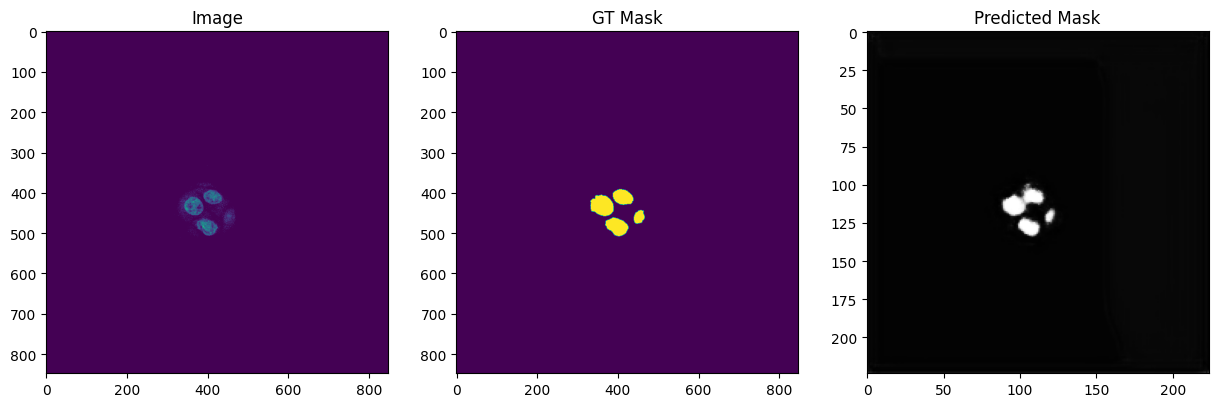

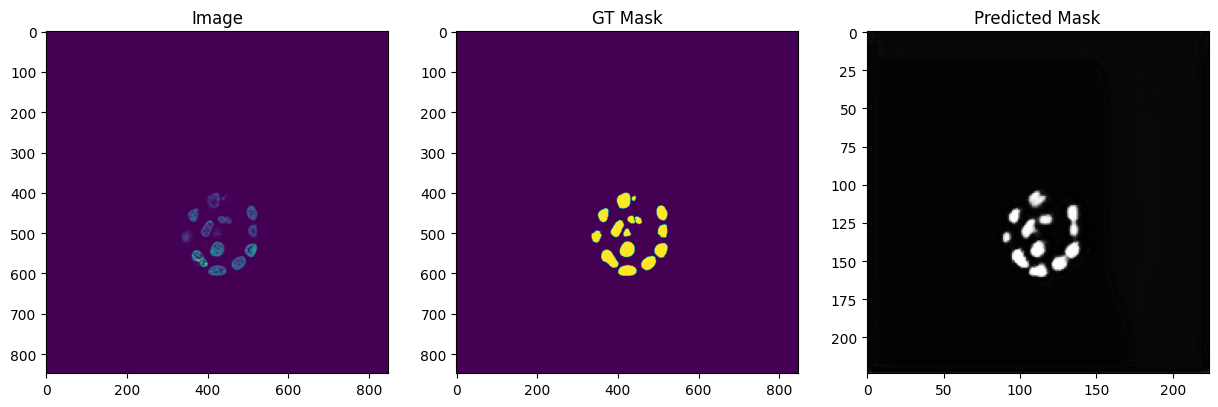

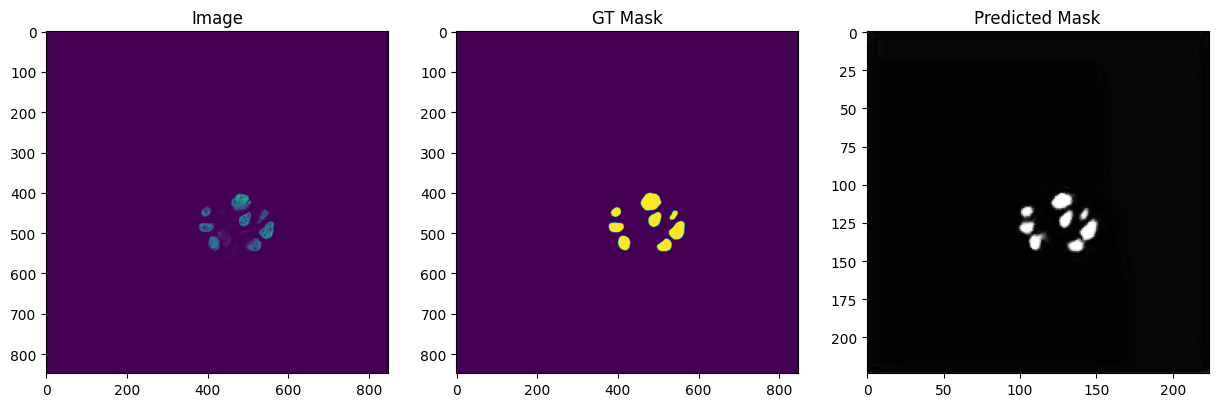

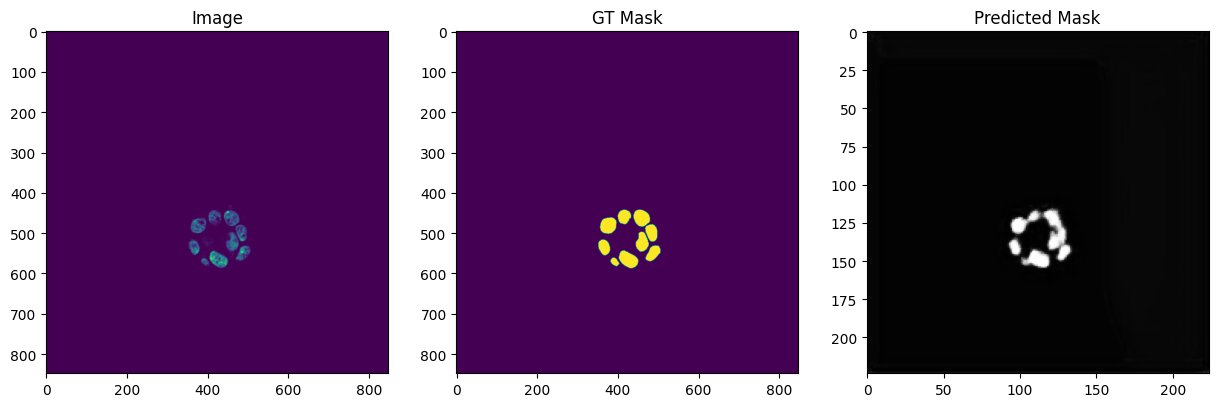

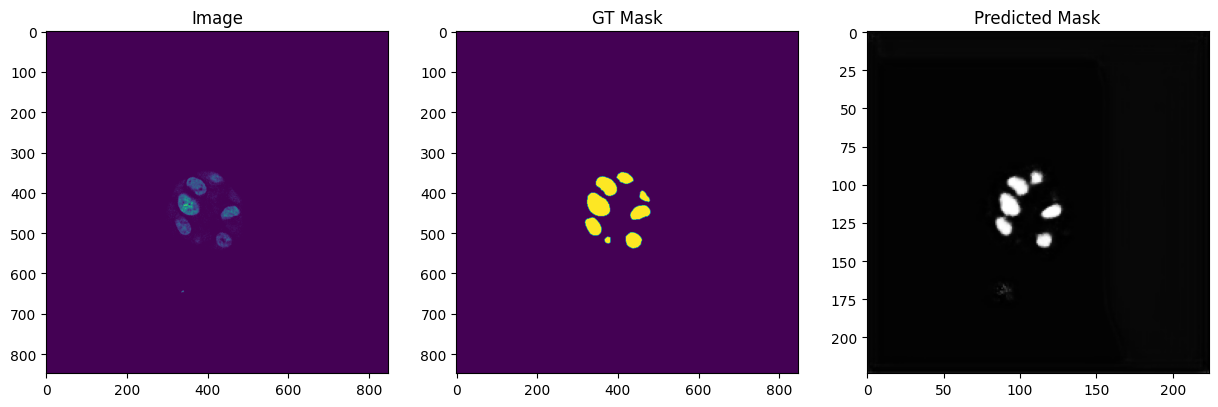

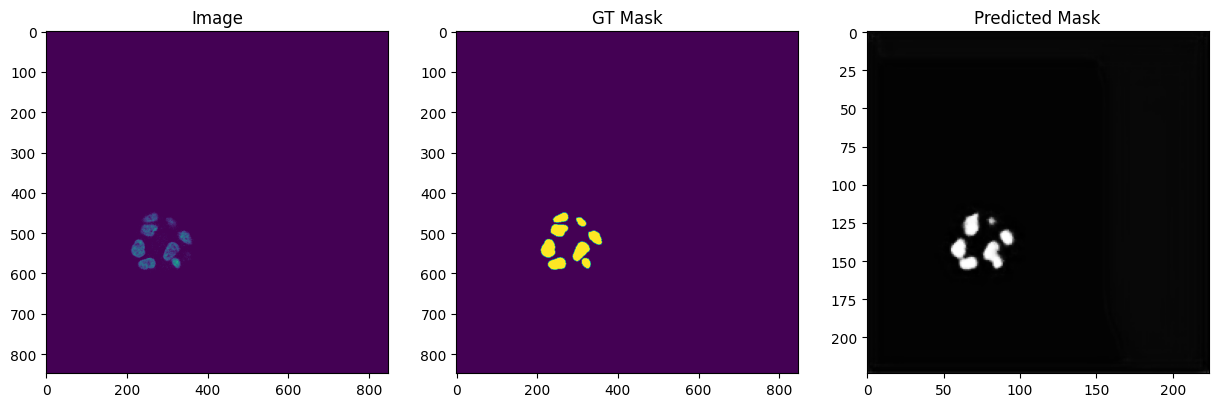

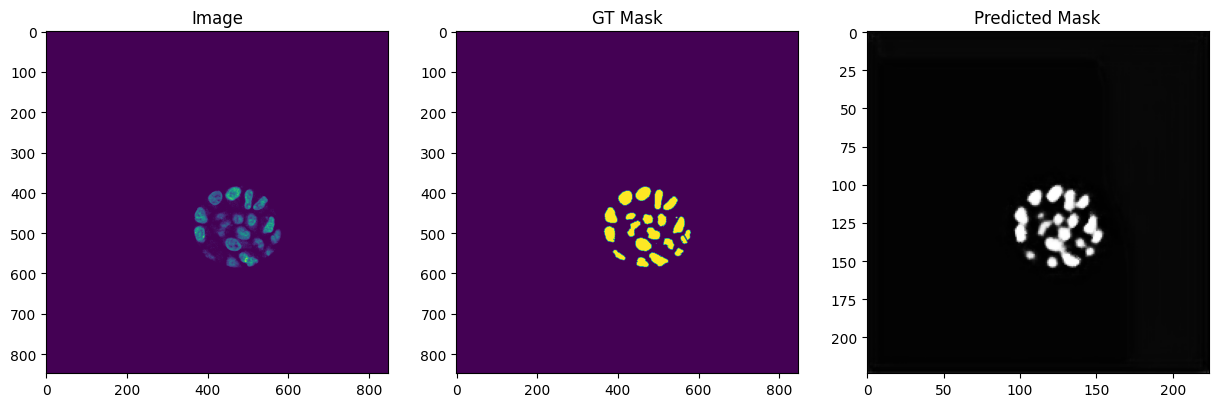

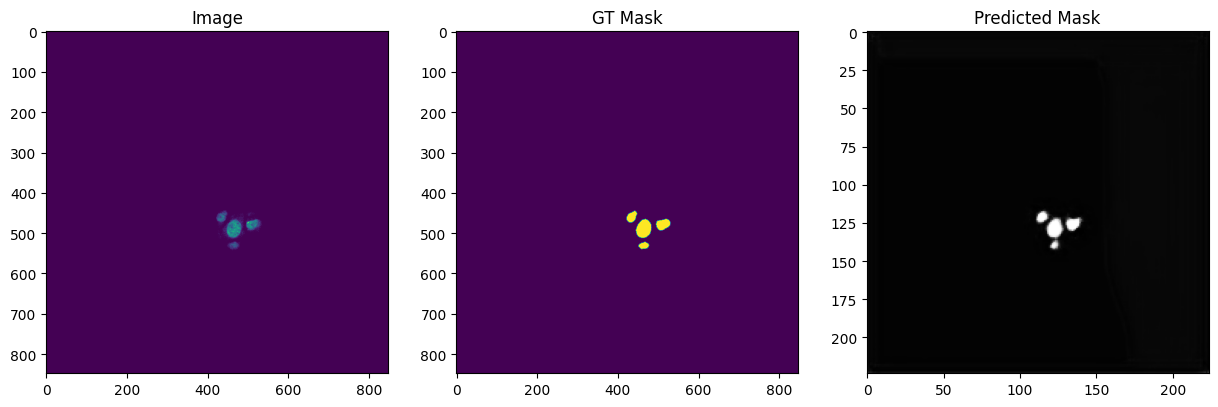

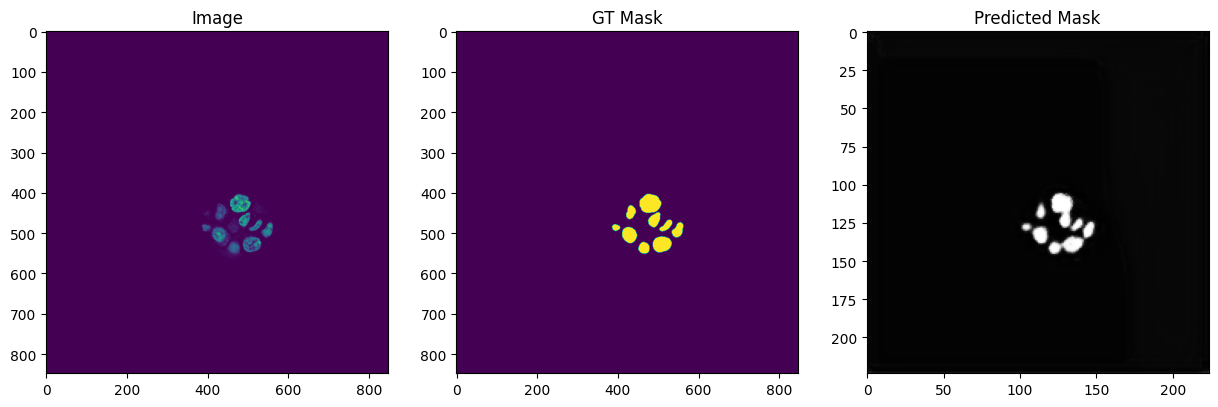

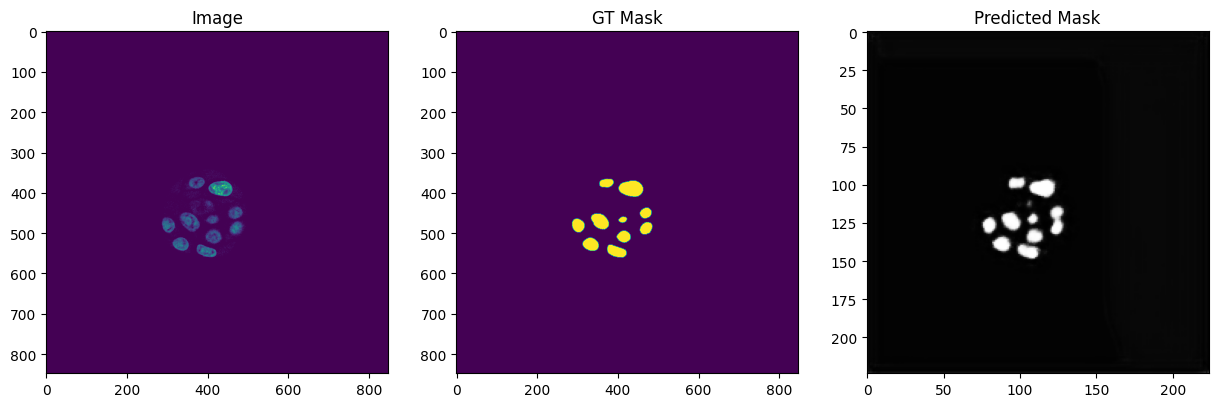

In [ ]:
import matplotlib.pyplot as plt

model.eval()

for i in range(10):
    img = test_files[i]
    x, y = val_dataset[i]
    output = model(torch.tensor(x.cuda()).unsqueeze(0)).detach().cpu().numpy()
    output = output.squeeze()

    # Process the model's output
    pred = (output[1, :, :] * 255).astype(np.uint8)
    output = output.reshape(224, 224, 2)
    output_image = np.zeros((224, 224, 3), dtype=np.uint8)

    # Map channel 0 to the red channel (foreground)
    output_image[:, :, 0] = (output[:, :, 1] * 255).astype(np.uint8)

    # Map channel 1 to the green channel (background)
    output_image[:, :, 1] = (output[:, :, 0] * 255).astype(np.uint8)

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(Image.open('/content/shared-data-sept/image/' + str(img)))
    axes[0].set_title('Image')

    # Plot the ground truth mask
    axes[1].imshow(Image.open('/content/shared-data-sept/mask/' + str(img)))
    axes[1].set_title('GT Mask')

    # Plot the predicted mask
    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title('Predicted Mask')

    plt.show()


**Plots**

In [ ]:
vals=[]
t = 0
for i in range(8):
  t=t+0.1

  metricst = [
      smp.utils.metrics.IoU(threshold=t),
      smp.utils.metrics.Precision(threshold=t),
      smp.utils.metrics.Recall(threshold=t),
      smp.utils.metrics.Accuracy(threshold=t),
      smp.utils.metrics.Fscore(threshold=t),
  ]

  valid_epoch = smp.utils.train.ValidEpoch(
      model,
      loss=loss,
      metrics=metricst,
      device=DEVICE,
      verbose=True,
  )

  valid_logs = valid_epoch.run(valid_loader)
  vals.append(valid_logs)

valid: 100%|██████████| 10/10 [00:00<00:00, 20.55it/s, dice_loss - 0.03489, iou_score - 0.9919, precision - 0.9991, recall - 0.9928, accuracy - 0.9959, fscore - 0.9959]


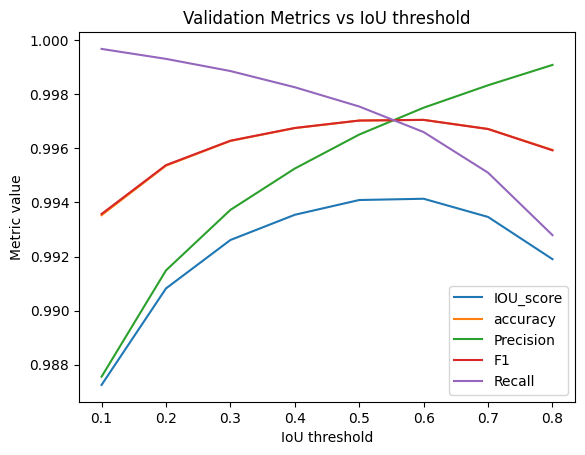

In [ ]:
t = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

iou = []
precision = []
f1 = []
recall = []
accuracy=[]

# Assuming train_logs_list and valid_logs_list contain loss values
for i in vals:
    iou.append(i['iou_score'])
    precision.append(i['precision'])
    f1.append(i['fscore'])
    recall.append(i['recall'])
    accuracy.append(i['accuracy'])

# Plot both training and validation losses
plt.plot(t,iou,label='IOU_score')
plt.plot(t, accuracy,label='accuracy')
plt.plot(t,precision, label='Precision')
plt.plot(t,f1, label='F1')
plt.plot(t,recall, label='Recall')

# Add labels, legend, and title
plt.xlabel('IoU threshold')
plt.ylabel('Metric value')
plt.legend()
plt.title('Validation Metrics vs IoU threshold')

# Show the plot
plt.show()


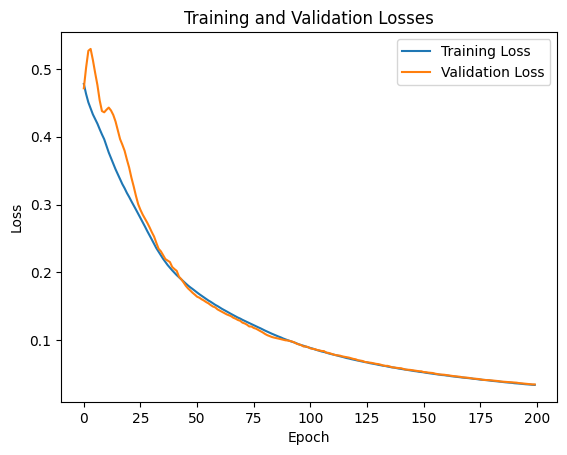

In [ ]:
import matplotlib.pyplot as plt

losses = []
val_losses = []

# Assuming train_logs_list and valid_logs_list contain loss values
for i, j in zip(train_logs_list, valid_logs_list):
    losses.append(i['dice_loss'])
    val_losses.append(j['dice_loss'])

# Plot both training and validation losses
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Add labels, legend, and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Show the plot
plt.show()


In [ ]:
train_logs_list[0]

{'dice_loss': 0.4778265357017517,
 'iou_score': 0.5186885644992193,
 'precision': 0.8790063261985779,
 'recall': 0.5508618056774139,
 'accuracy': 0.746032694975535,
 'fscore': 0.6446881194909414}

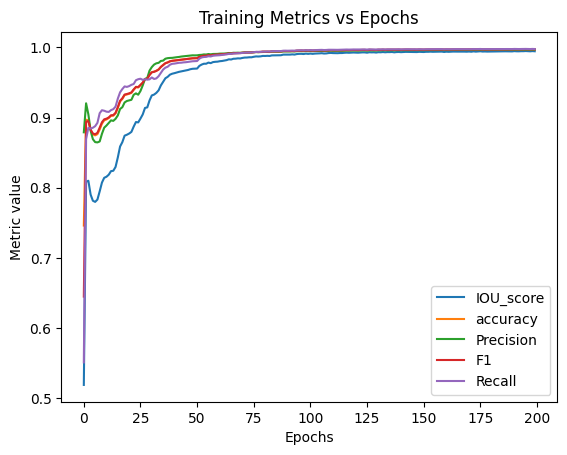

In [ ]:
import matplotlib.pyplot as plt

losses = []
precision = []
f1 = []
recall = []
accuracy=[]

# Assuming train_logs_list and valid_logs_list contain loss values
for i, j in zip(train_logs_list, valid_logs_list):
    losses.append(i['iou_score'])
    precision.append(i['precision'])
    f1.append(i['fscore'])
    recall.append(i['recall'])
    accuracy.append(i['accuracy'])

# Plot both training and validation losses
plt.plot(losses,label='IOU_score')
plt.plot(accuracy, label='accuracy')
plt.plot(precision, label='Precision')
plt.plot(f1, label='F1')
plt.plot(recall, label='Recall')

# Add labels, legend, and title
plt.xlabel('Epochs')
plt.ylabel('Metric value')
plt.legend()
plt.title('Training Metrics vs Epochs')

# Show the plot
plt.show()


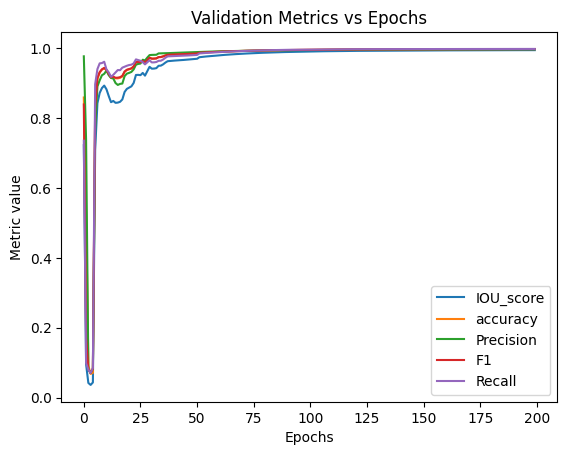

In [ ]:
import matplotlib.pyplot as plt

losses = []
precision = []
f1 = []
recall = []
accuracy=[]

# Assuming train_logs_list and valid_logs_list contain loss values
for i, j in zip(train_logs_list, valid_logs_list):
    losses.append(j['iou_score'])
    precision.append(j['precision'])
    f1.append(j['fscore'])
    recall.append(j['recall'])
    accuracy.append(j['accuracy'])

# Plot both training and validation losses
plt.plot(losses,label='IOU_score')
plt.plot(accuracy, label='accuracy')
plt.plot(precision, label='Precision')
plt.plot(f1, label='F1')
plt.plot(recall, label='Recall')

# Add labels, legend, and title
plt.xlabel('Epochs')
plt.ylabel('Metric value')
plt.legend()
plt.title('Validation Metrics vs Epochs')

# Show the plot
plt.show()


In [ ]:
!cp /content/best_model.pth /content/drive/MyDrive/best_model.pth

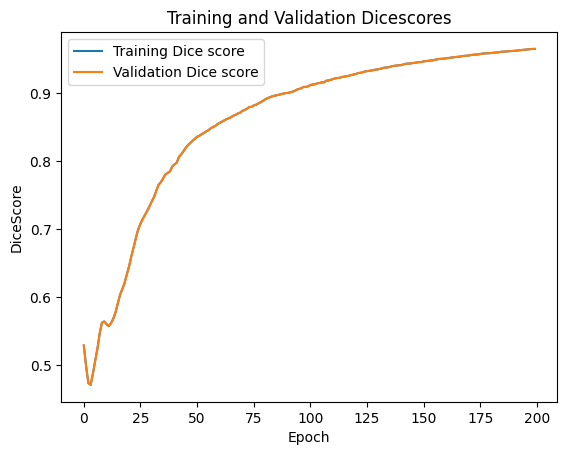

In [ ]:
import matplotlib.pyplot as plt


# Plot both training and validation losses
plt.plot(train, label='Training Dice score')
plt.plot(vals, label='Validation Dice score')

# Add labels, legend, and title
plt.xlabel('Epoch')
plt.ylabel('DiceScore')
plt.legend()
plt.title('Training and Validation Dicescores')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt


# helper function for plotting
def visualize(**images):
  """PLot images in one row."""
  n = len(images)
  plt.figure(figsize=(16, 5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
    plt.show()



# helper function for data visualization
def denormalize(x):
  """Scale image to range 0..1 for correct plot"""
  x_max = np.percentile(x, 98)
  x_min = np.percentile(x, 2)
  x = (x - x_min) / (x_max - x_min)
  x = x.clip(0, 1)
  return x